In [1]:
import numpy as np
from DP.utils import fisher_gradient, fisher_information_privatized, is_epsilon_private
import cvxpy as cp

def project_onto_feasible_set(Q, epsilon):
    n_plus_1 = Q.shape[0]
    Q_var = cp.Variable((n_plus_1, n_plus_1))
    Q_param = Q

    # Objective: minimize ||Q_var - Q_param||_F^2
    objective = cp.Minimize(cp.log_sum_exp(Q_var - Q_param))

    # Constraints
    constraints = []

    # Non-negativity
    constraints += [Q_var >= 0]

    # Column sums
    for j in range(n_plus_1):
        constraints += [cp.sum(Q_var[:, j]) == 1]

    # ε-Differential Privacy constraints
    exp_eps = np.exp(epsilon)
    exp_neg_eps = np.exp(-epsilon)
    for i in range(n_plus_1):
        for j in range(n_plus_1):
            for j_prime in range(n_plus_1):
                if j < j_prime:
                    constraints += [Q_var[i, j] - exp_neg_eps * Q_var[i, j_prime] >= 0]
                    constraints += [exp_eps * Q_var[i, j_prime] - Q_var[i, j] >= 0]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)

    return Q_var.value


def linesearch(p_theta, p_theta_dot, epsilon, q, n, theta):
    max_iters = 100
    alpha_init = 0.1
    beta = 0.8
    c = 1e-4
    history = [q]

    for t in range(max_iters):
        I_current = fisher_information_privatized(q, n, theta)
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)

        alpha = alpha_init
        while True:
            q_new = q + alpha * grad_I
            q_new = project_onto_feasible_set(q_new, epsilon)

            I_new = fisher_information_privatized(q_new, n, theta)

            if I_new >= I_current + c * alpha * np.sum(grad_I + (q_new - q)):
                break
            else:
                alpha *= beta

            if alpha < 1e-8:
                print("Line search failed to find a suitable step size.")

        if np.allclose(q, q_new):
            status = f"Converged after {t+1} iterations."
            break

        if abs(I_current - I_new) < 1e-8:
            status = f"Converged after {t+1} iteratons."
            break

        q = q_new
        history.append(q)
        status = "Max iterations reached without convergence"
    
    return {"Q_matrix": q, "status": status, "history": history}

In [2]:
from scipy.stats import binom
from DP.utils import binom_derivative
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use("ggplot")

n = 1
theta = 0.1
epsilon = 1.0

p_theta = binom.pmf([0, 1], 1, theta)
p_theta_dot = [binom_derivative(i, n, theta) for i in range(2)]
p_theta

array([0.9, 0.1])

In [4]:
n_vals = 50

a_vals = np.linspace(0, 1, n_vals)
b_vals = np.linspace(0, 1, n_vals)

grads_a = list()
grads_b = list()
private = list()
fishers = list()

for a in a_vals:
    for b in b_vals:
        q_mat = np.array([[a, b], [1-a, 1-b]])
        grad = fisher_gradient(p_theta, p_theta_dot, q_mat)

        fishers.append(fisher_information_privatized(q_mat, p_theta, p_theta_dot))
        private.append(is_epsilon_private(q_mat, epsilon))

        grads_a.append(grad[0, 0])
        grads_b.append(grad[0, 1])

/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:104: RuntimeWarning: invalid value encountered in divide
  2 * np.outer(p_theta_dot, Q_ptheta_dot) / Q_ptheta
/Users/matej.vedak/Desktop/University of Vienna/Lukas master thesis/locally_efficient_differential_privacy/DP/utils.py:105: RuntimeWarning: invalid value encountered in divide
  - np.outer(p_theta, Q_ptheta_dot_squared) / Q_ptheta_squared


In [7]:
from DP.linear_solver import LinearSolver
from DP.utils import binom_optimal_privacy

opt_solutions, _, _, _ = binom_optimal_privacy(LinearSolver(), n, epsilon, theta)
xs = opt_solutions[:, 0]
ys = opt_solutions[:, 1]

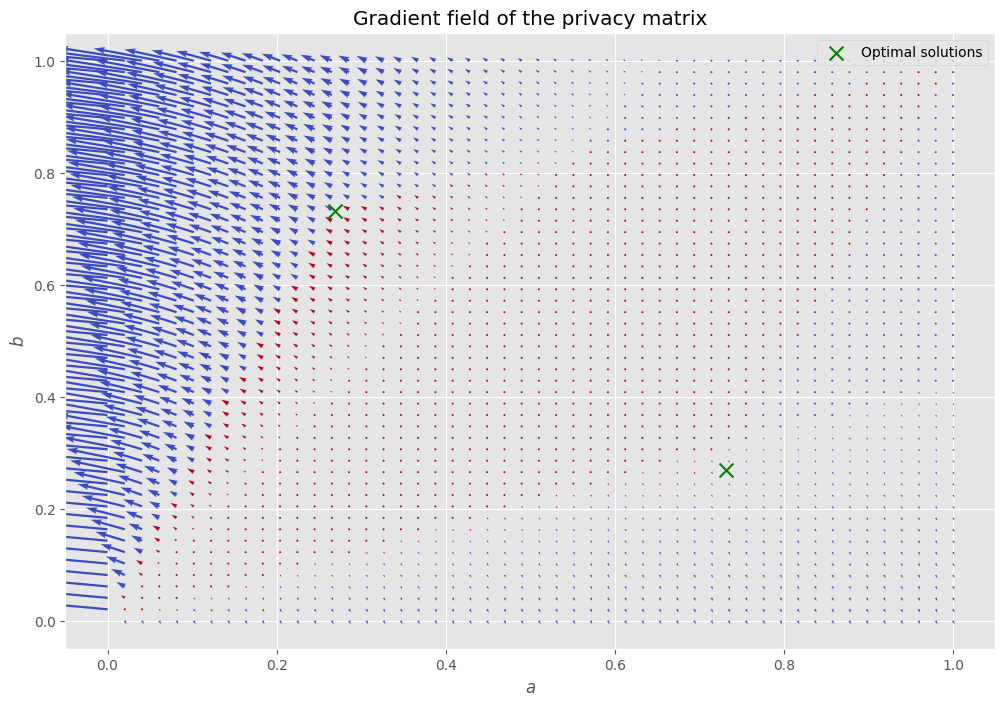

In [8]:
grads_a = np.array(grads_a).reshape((n_vals, n_vals), order="F")
grads_b = np.array(grads_b).reshape((n_vals, n_vals), order="F")
private = np.array(private).reshape((n_vals, n_vals), order="F")
fishers = np.array(fishers).reshape((n_vals, n_vals), order="F")

fig, ax = plt.subplots(figsize=(12, 8))
plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.title("Gradient field of the privacy matrix")
plt.show()

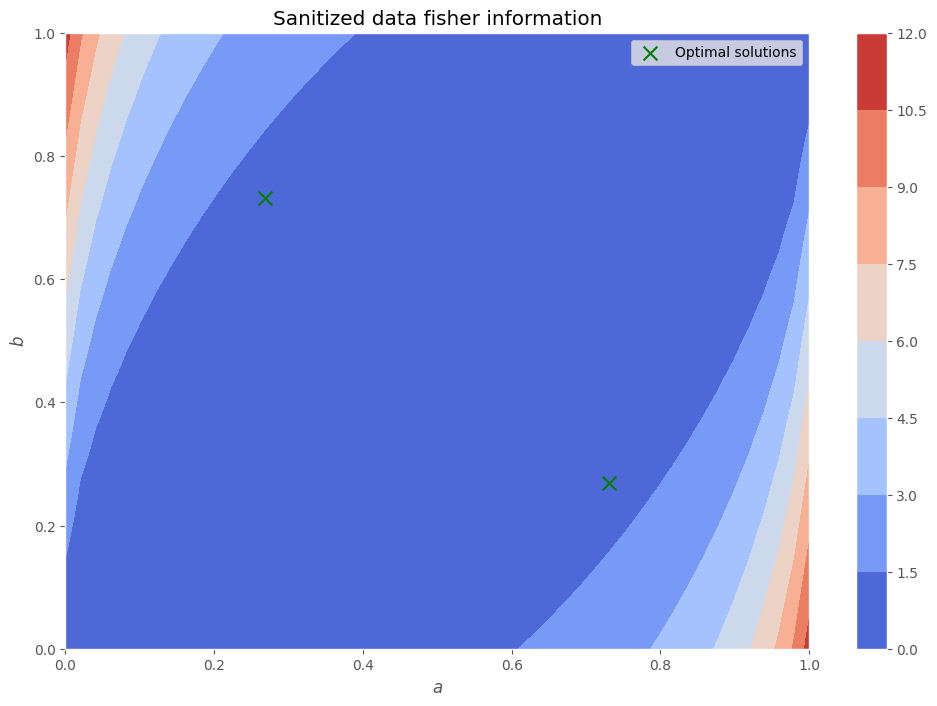

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title("Sanitized data fisher information")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()

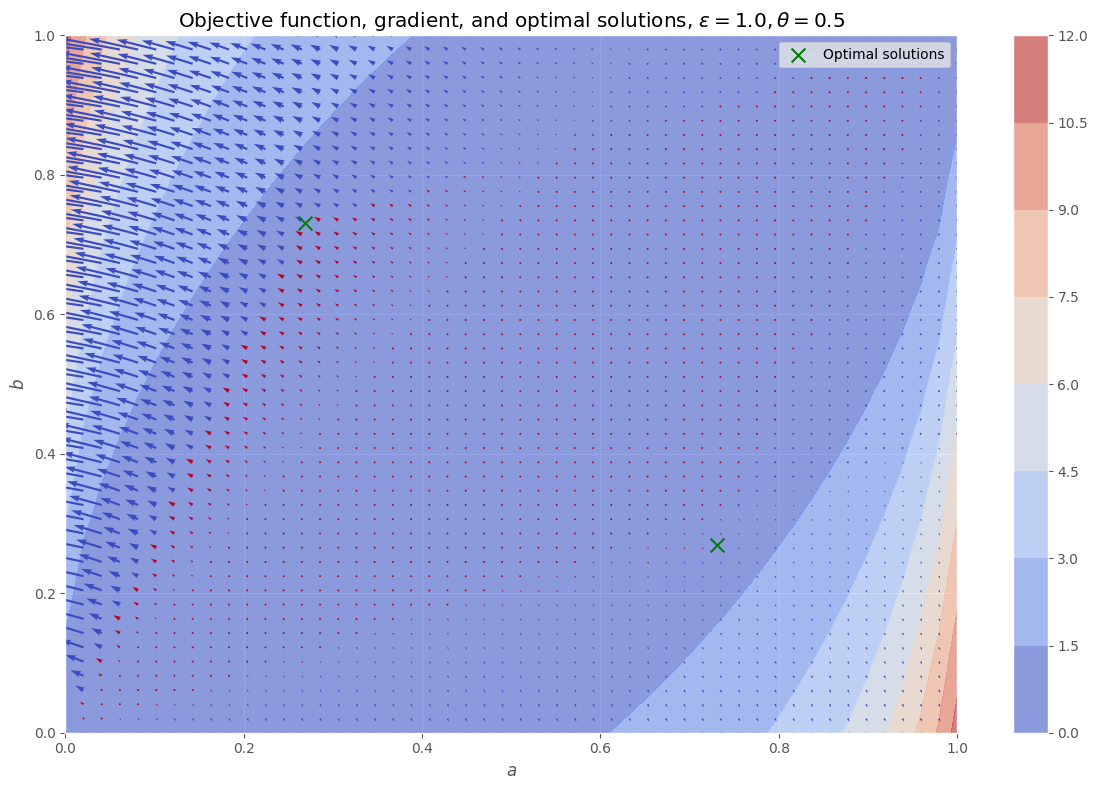

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.6)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.title(r"Objective function, gradient, and optimal solutions, $\epsilon = 1.0, \theta = 0.5$")
plt.tight_layout()
plt.show()

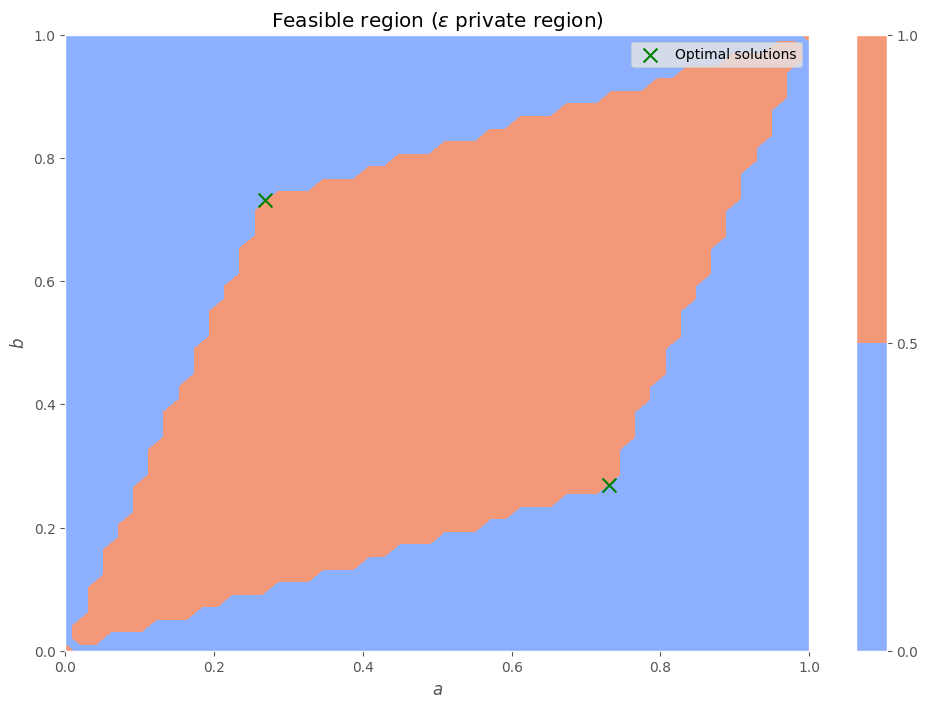

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, private, cmap="coolwarm")
plt.colorbar()
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.title(r"Feasible region ($\epsilon$ private region)")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
plt.legend()
plt.show()

In [17]:
def projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon):
    history = [Q_init]
    grads = list()
    fish = fisher_information_privatized(Q_init, p_theta, p_theta_dot)
    q = Q_init

    for i in range(100):
        grad_I = fisher_gradient(p_theta, p_theta_dot, q)
        # grad_I = grad_I / np.max(grad_I)
        grad_I[-1, :] = 0
        q_raw = q + 0.1 * grad_I
        
        if is_epsilon_private(q_raw, epsilon):
            q_new = q_raw
        else:
            history.append(q_raw)
            q_new = project_onto_feasible_set(q_raw, epsilon)

        fish_next = fisher_information_privatized(q_new, p_theta, p_theta_dot)

        if np.allclose(q, q_new):
            status = f"Converged after {i+1} iterations."
            break

        if abs(fish - fish_next) < 1e-8:
            status = f"Converged after {i+1} iteratons."
            break
        
        q = q_new
        fish = fish_next

        grads.append(grad_I)
        history.append(q)

    return history, grads

Q_init = np.ones((n + 1, n + 1)) / (n + 1) + np.random.normal(size=(n+1, n+1), scale=0.1)
Q_init = project_onto_feasible_set(Q_init, epsilon)
history, grads = projected_gradient_ascent(Q_init, p_theta, p_theta_dot, n, theta, epsilon)

In [18]:
all_history = np.array(history)

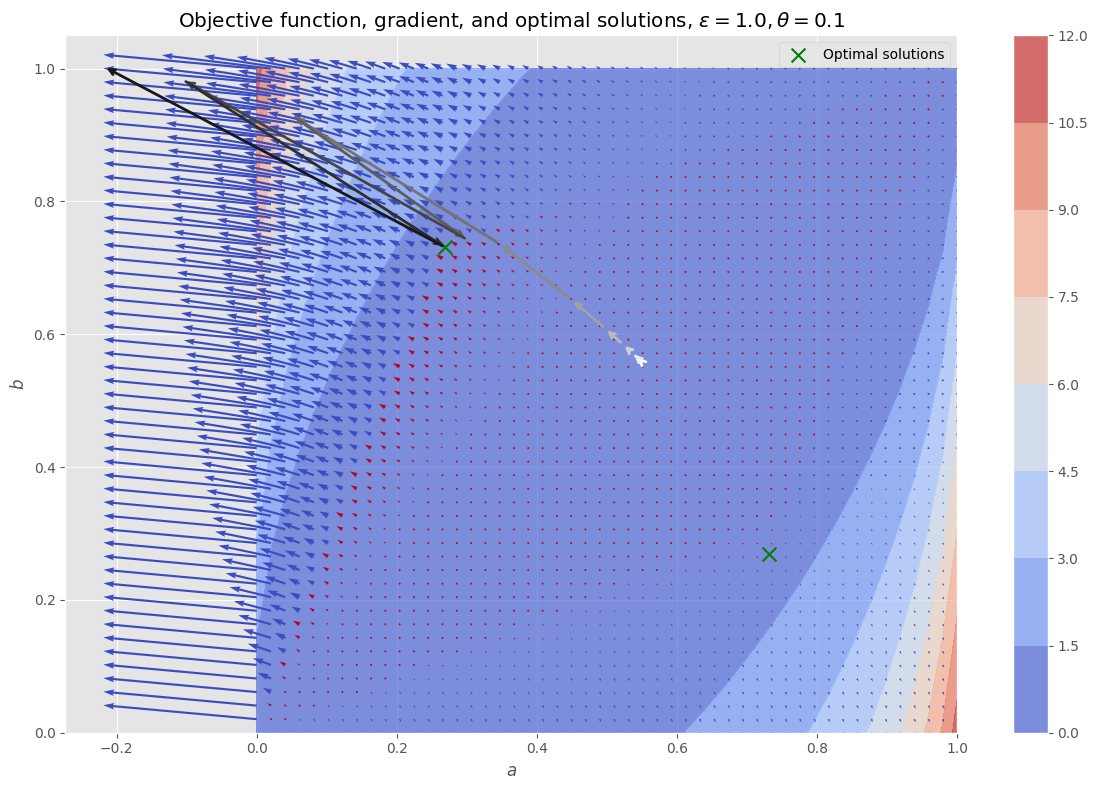

In [19]:
from matplotlib.patches import FancyArrowPatch

colors = plt.cm.binary(np.linspace(0, 1, len(all_history)))

fig, ax = plt.subplots(figsize=(12, 8))

plt.contourf(a_vals, b_vals, fishers, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.quiver(a_vals, b_vals, grads_a, grads_b, private, cmap="coolwarm")
plt.xlabel("$a$")
plt.ylabel("$b$")
plt.scatter(xs, ys, color="green", label="Optimal solutions", marker="x", s=100)
#plt.scatter(all_history[:,0,0], all_history[:,0,1], marker="x", s=100, label="Sample path", c=colors)
for i in range(len(all_history) - 1):
    arrow = FancyArrowPatch((all_history[i,0,0], all_history[i,0,1]), (all_history[i+1,0,0], all_history[i+1,0,1]), 
                             color=colors[i], arrowstyle='->', mutation_scale=10, linewidth=2)
    ax.add_patch(arrow)
plt.legend()
plt.title(fr"Objective function, gradient, and optimal solutions, $\epsilon = {epsilon}, \theta = {theta}$")
plt.tight_layout()
plt.show()